### Slade Brooks
##### brooksl@mail.uc.edu
##### 02.03.2023
# AeroComputing Assignment 3

This code solves [A]{x}={b} matrix systems using direct and iterative methods. First, it uses 2 iterative and 3 direct and compares them. Then, it solves a temperature gradient in physical space using one of the methods. It does this with a 3x3 physical mesh and then with a 40x40 physical mesh and compares the performance. It also uses this to calculate the order of operations of the process to prove that it is faster than the direct methods.

# Part 1

In [675]:
# import shtuff
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd
import sys

# import custom modules
sys.path.append("..//lib//")
import pyvot        # pivot direct and iterative methods

# Part 2

In [676]:
# define a and b
a = np.zeros((20, 20), dtype="float64")
for i in range(20):
    a[i, i] = 4.
    if i < 19:
        a[i, i+1] = -1.
        a[i+1, i] = -1.
a[0, 19] = 1.
a[19, 0] = 1.

b = np.zeros((20, 1), dtype="float64")
b[19, 0] = 100.

In [677]:
# compute each of direct methods and time them

# gauss pivot
t0 = time.perf_counter()
gauss = pyvot.gaussPivot(a.copy(), b.copy())
gausstime = time.perf_counter() - t0
# gauss residual
gaussres = np.linalg.norm(np.dot(a.copy(), gauss) - b.copy())

# LU
t0 = time.perf_counter()
LUcomp = pyvot.LUdecomp(a.copy())
LUa, seq = LUcomp
LUsolve = pyvot.LUsolve(LUa.copy(), b.copy(), seq.copy())
LUtime = time.perf_counter() - t0
# LU residual
LUres = np.linalg.norm(np.dot(a.copy(), LUsolve) - b.copy())

# cramer
t0 = time.perf_counter()
cramer = pyvot.cramer(a.copy(), b.copy())
cramertime = time.perf_counter() - t0
# cramer residual
cramres = np.linalg.norm(np.dot(a.copy(), cramer) - b.copy())

# print solutions
print("gauss:",gauss)
print("LU:",LUsolve)
print("cramer:",cramer)


gauss: [[-7.73502692e+00]
 [-2.07259421e+00]
 [-5.55349941e-01]
 [-1.48805549e-01]
 [-3.98722562e-02]
 [-1.06834753e-02]
 [-2.86164518e-03]
 [-7.63105381e-04]
 [-1.90776345e-04]
 [-3.63138871e-20]
 [ 1.90776345e-04]
 [ 7.63105381e-04]
 [ 2.86164518e-03]
 [ 1.06834753e-02]
 [ 3.98722562e-02]
 [ 1.48805549e-01]
 [ 5.55349941e-01]
 [ 2.07259421e+00]
 [ 7.73502692e+00]
 [ 2.88675135e+01]]
LU: [[-7.73502692e+00]
 [-2.07259421e+00]
 [-5.55349941e-01]
 [-1.48805549e-01]
 [-3.98722562e-02]
 [-1.06834753e-02]
 [-2.86164518e-03]
 [-7.63105381e-04]
 [-1.90776345e-04]
 [-3.63138871e-20]
 [ 1.90776345e-04]
 [ 7.63105381e-04]
 [ 2.86164518e-03]
 [ 1.06834753e-02]
 [ 3.98722562e-02]
 [ 1.48805549e-01]
 [ 5.55349941e-01]
 [ 2.07259421e+00]
 [ 7.73502692e+00]
 [ 2.88675135e+01]]
cramer: [[-7.73502692e+00]
 [-2.07259421e+00]
 [-5.55349941e-01]
 [-1.48805549e-01]
 [-3.98722562e-02]
 [-1.06834753e-02]
 [-2.86164518e-03]
 [-7.63105381e-04]
 [-1.90776345e-04]
 [ 0.00000000e+00]
 [ 1.90776345e-04]
 [ 7.63105

In [678]:
# define interEqs fxn for gaussSeidel
def iterEqs(x, omega):
    n = len(x)
    x[0] = omega*(x[1] - x[n-1])/4.0 + (1.0 - omega)*x[0]
    for i in range(1, n-1):
        x[i] = omega*(x[i-1] + x[i+1])/4.0 + (1.0 - omega)*x[i]
    x[n-1] = omega*(100. - x[0] + x[n-2])/4.0 \
        + (1.0 - omega)*x[n-1]
    return x

# do gaussSeidel method and time it
x = np.zeros(20)        # because n = 20
t0 = time.perf_counter()
gaussSeidel,numIter,omega = pyvot.gaussSeidel(iterEqs,x)
gaussSeideltime = time.perf_counter() - t0
print("\nNumber of iterations =",numIter)
print("\nRelaxation factor =",omega)
print("\nThe solution is:\n",gaussSeidel)

# residual
b = np.zeros(20)
b[19] = 100.
gaussSeidelres = np.linalg.norm(np.dot(a.copy(), gaussSeidel.copy()) - b.copy())


Number of iterations = 21

Relaxation factor = 1.097679755833418

The solution is:
 [-7.73502692e+00 -2.07259421e+00 -5.55349941e-01 -1.48805549e-01
 -3.98722562e-02 -1.06834753e-02 -2.86164518e-03 -7.63105381e-04
 -1.90776345e-04  8.65000954e-14  1.90776346e-04  7.63105381e-04
  2.86164518e-03  1.06834753e-02  3.98722562e-02  1.48805549e-01
  5.55349941e-01  2.07259421e+00  7.73502692e+00  2.88675135e+01]


In [679]:
# define Av for conj
def Ax(v):
    n = len(v)
    Ax = np.zeros(n)
    Ax[0] = 4.0*v[0] - v[1]+v[n-1]
    Ax[1:n-1] = -v[0:n-2] + 4.0*v[1:n-1] -v[2:n]
    Ax[n-1] = -v[n-2] + 4.0*v[n-1] + v[0]
    return Ax

# do conjGrad method and time it
b = np.zeros(20)
b[19] = 100.
x = np.zeros(20)
t0 = time.perf_counter()
conjGrad,numIter = pyvot.conjGrad(Ax,x,b.copy())
conjGradtime = time.perf_counter() - t0
print("\nThe solution is:\n",conjGrad)
print("\nNumber of iterations =",numIter)

# residual
conjGradres = np.linalg.norm(np.dot(a.copy(), conjGrad.copy()) - b.copy())


The solution is:
 [-7.73502692e+00 -2.07259421e+00 -5.55349941e-01 -1.48805549e-01
 -3.98722562e-02 -1.06834753e-02 -2.86164518e-03 -7.63105381e-04
 -1.90776345e-04  0.00000000e+00  1.90776345e-04  7.63105381e-04
  2.86164518e-03  1.06834753e-02  3.98722562e-02  1.48805549e-01
  5.55349941e-01  2.07259421e+00  7.73502692e+00  2.88675135e+01]

Number of iterations = 9


In [680]:
# create and print a table of the performance

# make a dictionary of the values
perf = {"Method": ["Gauss Pivot", "LU Pivot", "Cramer", "Gauss-Seidel", "Conjugate Gradient"],
        "Compute Time": [gausstime, LUtime, cramertime, gaussSeideltime, conjGradtime],
        "Residual": [gaussres, LUres, cramres, gaussSeidelres, conjGradres]}

# create a pandas dataframe
df = pd.DataFrame(perf)

# output table
print(df)

               Method  Compute Time      Residual
0         Gauss Pivot      0.000545  2.826729e-15
1            LU Pivot      0.000415  2.826729e-15
2              Cramer      0.000359  1.883435e-13
3        Gauss-Seidel      0.000482  1.763285e-10
4  Conjugate Gradient      0.000498  1.709849e-14


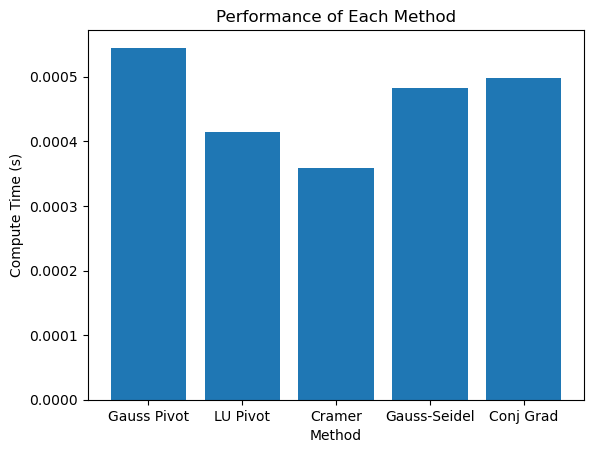

In [681]:
# make a plot of performance also

plt.bar(("Gauss Pivot","LU Pivot","Cramer","Gauss-Seidel","Conj Grad"),(gausstime,LUtime,cramertime,gaussSeideltime,conjGradtime))
plt.ylabel("Compute Time (s)")
plt.xlabel("Method")
plt.title("Performance of Each Method")
plt.show()

We can see from the above table that for the sparse matrix, the direct methods typically take the longest. This makes sense because the iterative methods are made for solving sparse matrices and should be faster. Sometimes the compute times are similar or backwards to expectations, but I think that is due to variation when the code runs and the small matrix size makes the methods take a similar amount of time.

# Part 3

In [682]:
# define fxn to create matrix for T thing from Dr. O code

def Ax2(T) :
    n = len(T)
    # create mesh
    Ax = np.zeros(n)

    # for indexing
    m = int(np.sqrt(n))

    # first vals
    Ax[0] = -4.0*T[0] + T[1] + T[m]

    # repeated vals
    for k in range(1, m - 1):
        Ax[k] = T[k - 1]-4.0*T[k] + T[k + 1] + T[k + m]
    k = m - 1
    
    #constant val
    Ax[k] = T[m - 2] - 4.0*T[m - 1] + T[2*m - 1]

    # surrounding points
    for i in range (1, m - 1):
        k = i*m

        # set p2
        Ax[k] = T[k - m] - 4.0*T[k] + T[k + 1] + T[k + m]
        for j in range(1, m - 1):
            k = i*m + j
            # set p3
            Ax[k] = T[k - m] + T[k - 1] - 4.0*T[k] + T[k + 1] + T[k + m]
        k = (i + 1)*m - 1
        Ax[k] = T[k - m] + T[k - 1] - 4.0*T[k] + T[k + m]
        k = (m - 1)*m
        Ax[k] = T[k - m] - 4.0*T[k] + T[k + 1]
        for j in range (1, m - 1):
            k = (m - 1)*m + j
            Ax[k] = T[k - m] + T[k - 1] - 4.0*T[k] + T[k + 1]
        k = m**2 - 1
        Ax[k] = T[k - m] + T[k - 1] - 4.0*T[k]

    # return mesh
    return Ax

## Part A

In [683]:
# solve problem with conjgrad and n=9

# create b for the problem
b9 = np.array([0, 0, -100, 0, -0, -100, -200, -200, -300],dtype="float64")

# create empty x
x9 = np.zeros(9)

# compute conjgrad
t0 = time.perf_counter()
conjGrad9,numIter9 = pyvot.conjGrad(Ax2,x9,b9.copy())
conjGradtime9 = time.perf_counter() - t0
print("\nThe solution is:\n",conjGrad9)
print("\nNumber of iterations =",numIter9)


The solution is:
 [ 21.42857143  38.39285714  57.14285714  47.32142857  75.
  90.17857143  92.85714286 124.10714286 128.57142857]

Number of iterations = 4


## Part B

In [684]:
# reshape conjGrad output to be a 2D array
conjGrad9 = conjGrad9.reshape([3, 3])

In [685]:
# add wall temp values back
# pad matrix
conjGrad9 = np.pad(conjGrad9, 1)

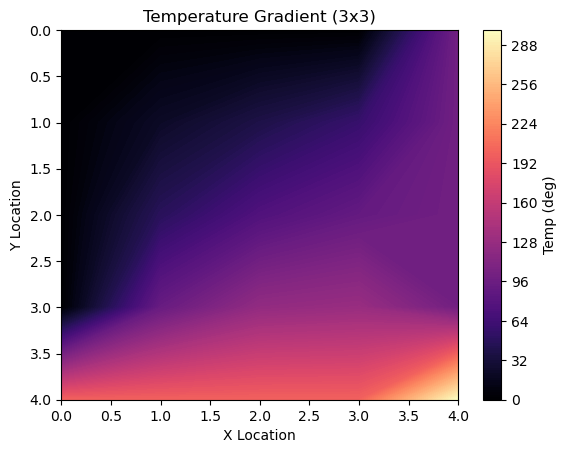

In [694]:
# replace wall values
conjGrad9[:,-1] = 100
conjGrad9[-1,:] = 200
conjGrad9[-1,-1] = 300

# set up an xy grid to plot with
x = np.arange(0, 5)
y = x

# plot contour plot with magma because scary ooh
plt.contourf(x, y, conjGrad9, cmap="magma", levels=150)
# invert axis to match problem diagram
plt.gca().invert_yaxis()
# formatting b/c yay
plt.xlabel("X Location")
plt.ylabel("Y Location")
plt.title("Temperature Gradient (3x3)")
plt.colorbar(label="Temp (deg)")
plt.show()

## Part C

In [687]:
# define function to create b for the n=40

def createB(n):
    # create array of long length
    # im doing 2d and then reshaping because its hard to visualize
    b40 = np.zeros((n, n), dtype="float64")

    # only need to do right side and bottom side and corner
    # go down right side except for last point
    b40[:,-1] = -100

    # go along bottom side except for last point
    b40[-1,:] = -200

    # set corner
    b40[-1, -1] = -300

    # reshape b to be 1D
    b40 = b40.flatten()

    return b40

In [688]:
# solve 40x40 with conjgrad

# create b array with function
b40 = createB(n=40)

# create empty x of n=40
x40 = np.zeros(1600)

# compute conjgrad
t0 = time.perf_counter()
conjGrad40,numIter40 = pyvot.conjGrad(Ax2,x40,b40.copy())
conjGradtime40 = time.perf_counter() - t0
print("\nThe solution is:\n",conjGrad40)
print("\nNumber of iterations =",numIter40)


The solution is:
 [  0.19542558   0.39045122   0.58468687 ... 178.47384242 169.3741811
 149.80457442]

Number of iterations = 139


### Part C.i

In [689]:
# reshape conjGrad output to be a 2D array
conjGrad40 = conjGrad40.reshape([40, 40])

In [690]:
# add wall temp values back
# pad matrix
conjGrad40 = np.pad(conjGrad40, 1)

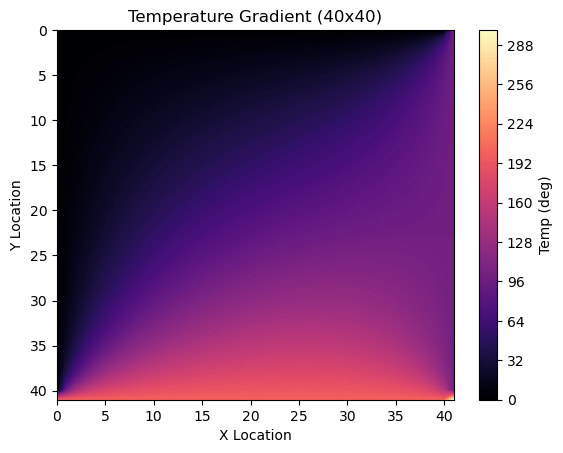

In [691]:
# replace wall values
conjGrad40[:,-1] = 100
conjGrad40[-1,:] = 200
conjGrad40[-1,-1] = 300

# set up an xy grid to plot with
x = np.arange(0, 42)
y = x

# plot contour plot with magma because scary ooh
plt.contourf(x, y, conjGrad40, cmap="magma", levels=150)
# invert axis to match problem diagram
plt.gca().invert_yaxis()
# formatting b/c yay
plt.xlabel("X Location")
plt.ylabel("Y Location")
plt.title("Temperature Gradient (40x40)")
plt.colorbar(label="Temp (deg)")
plt.show()

### Part C.ii

In [695]:
# create and print a table of the performance

# make a dictionary of the values
perf = {"Size": ["3x3", "40x40"],
        "Compute Time": [conjGradtime9, conjGradtime40],
        "Iterations": [numIter9, numIter40]}

# create a pandas dataframe
df = pd.DataFrame(perf)

# output table
print(df)

    Size  Compute Time  Iterations
0    3x3      0.000698           4
1  40x40      0.581511         139


In [693]:
# calc order of operations
x = (np.log(conjGradtime40/conjGradtime9)/np.log(40/3))

print("Order of Operations =",x)

Order of Operations = 2.5960447487689122
